In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import math, operator

import warnings
warnings.filterwarnings('ignore')

# визуализация процесса apply
from tqdm import tqdm
tqdm.pandas()

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tqdm import TQDMNotebookCallback

seed = 48
np.random.seed(seed) # фиксируем seed

Using TensorFlow backend.


In [2]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [3]:
series = pd.read_csv('pollution.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [4]:
series["unix_timestamp"] = series.index.astype(np.int64) // 10**9

In [5]:
series.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain', 'unix_timestamp'],
      dtype='object')

In [6]:
df = series[["pollution","rain","snow"]]
df = (df - df.min()) / (df.max() - df.min())

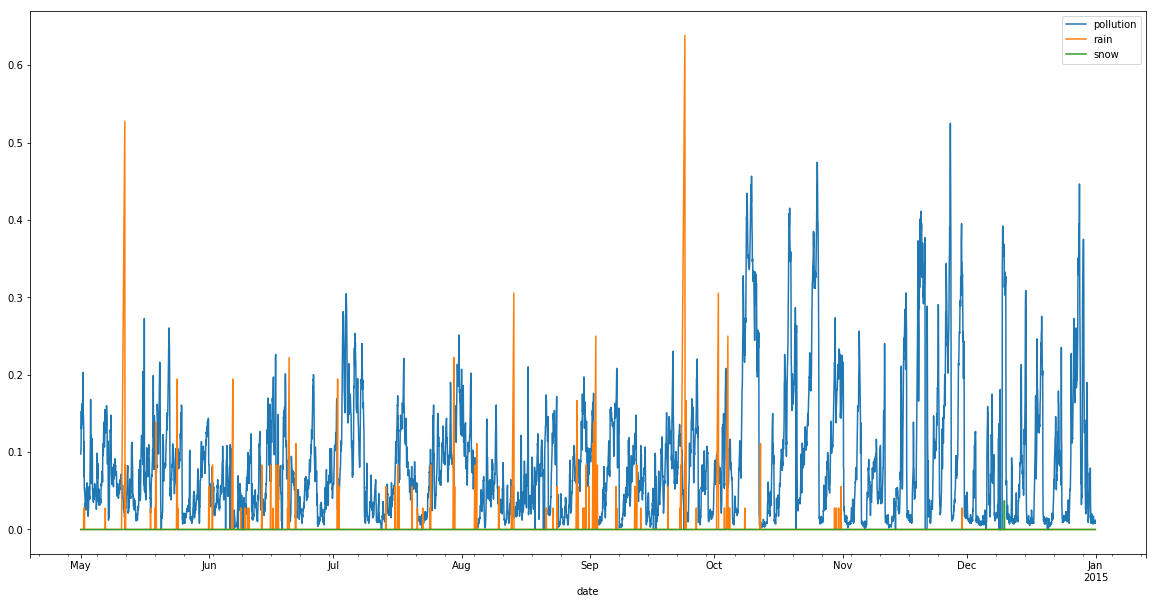

In [7]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

In [8]:
df = series[["pollution","temp","press"]]
df = (df - df.min()) / (df.max() - df.min())

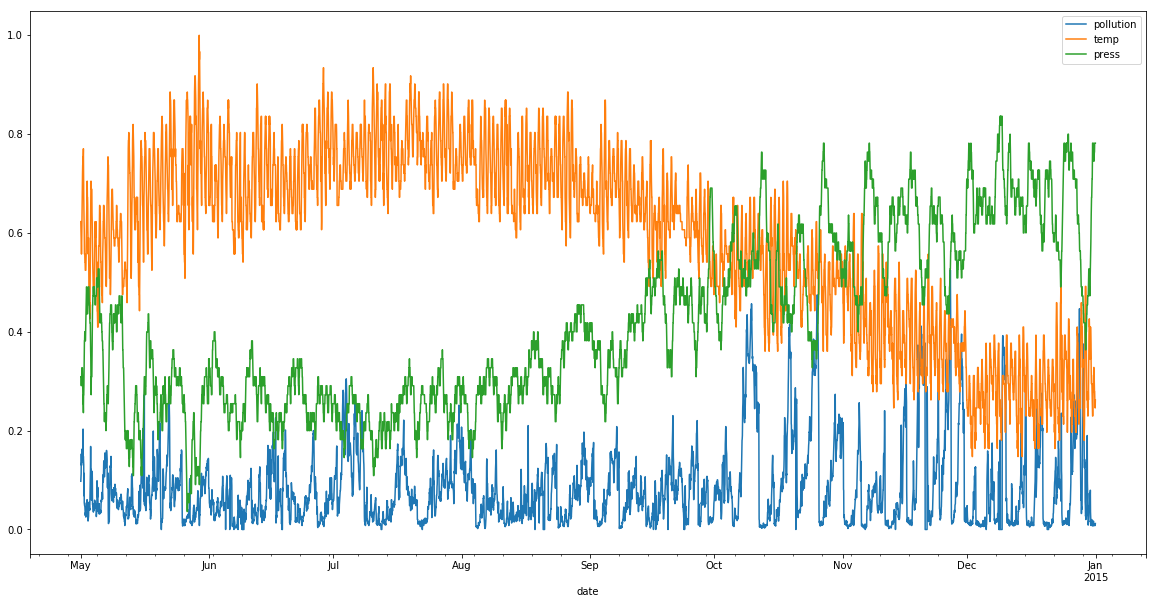

In [9]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

In [10]:
df = series[["pollution","wnd_spd"]]
df = (df - df.min()) / (df.max() - df.min())

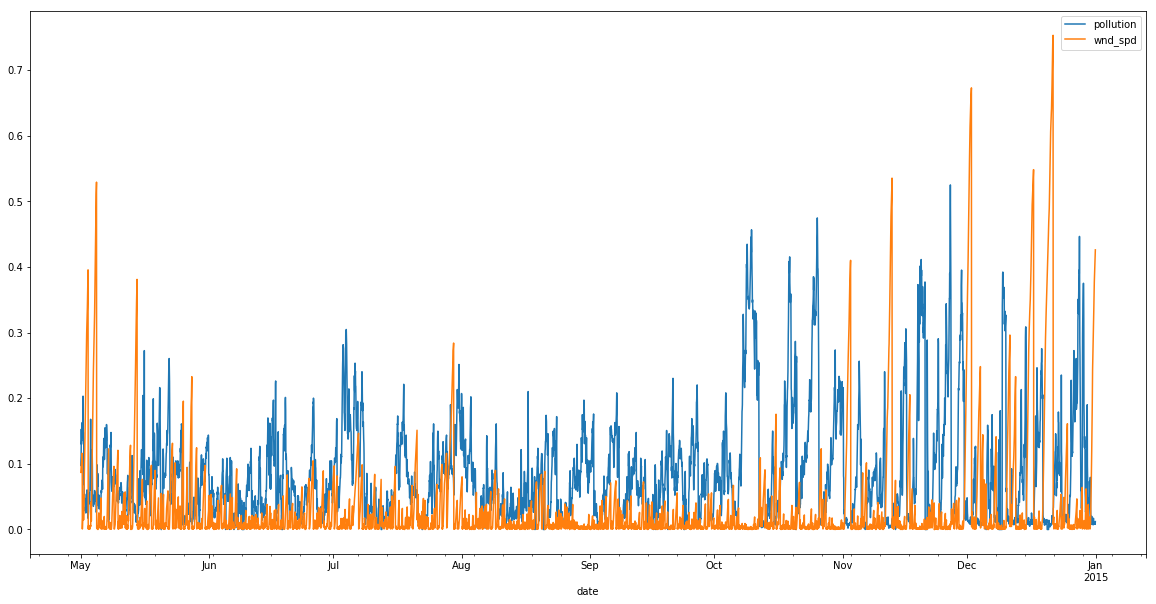

In [11]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

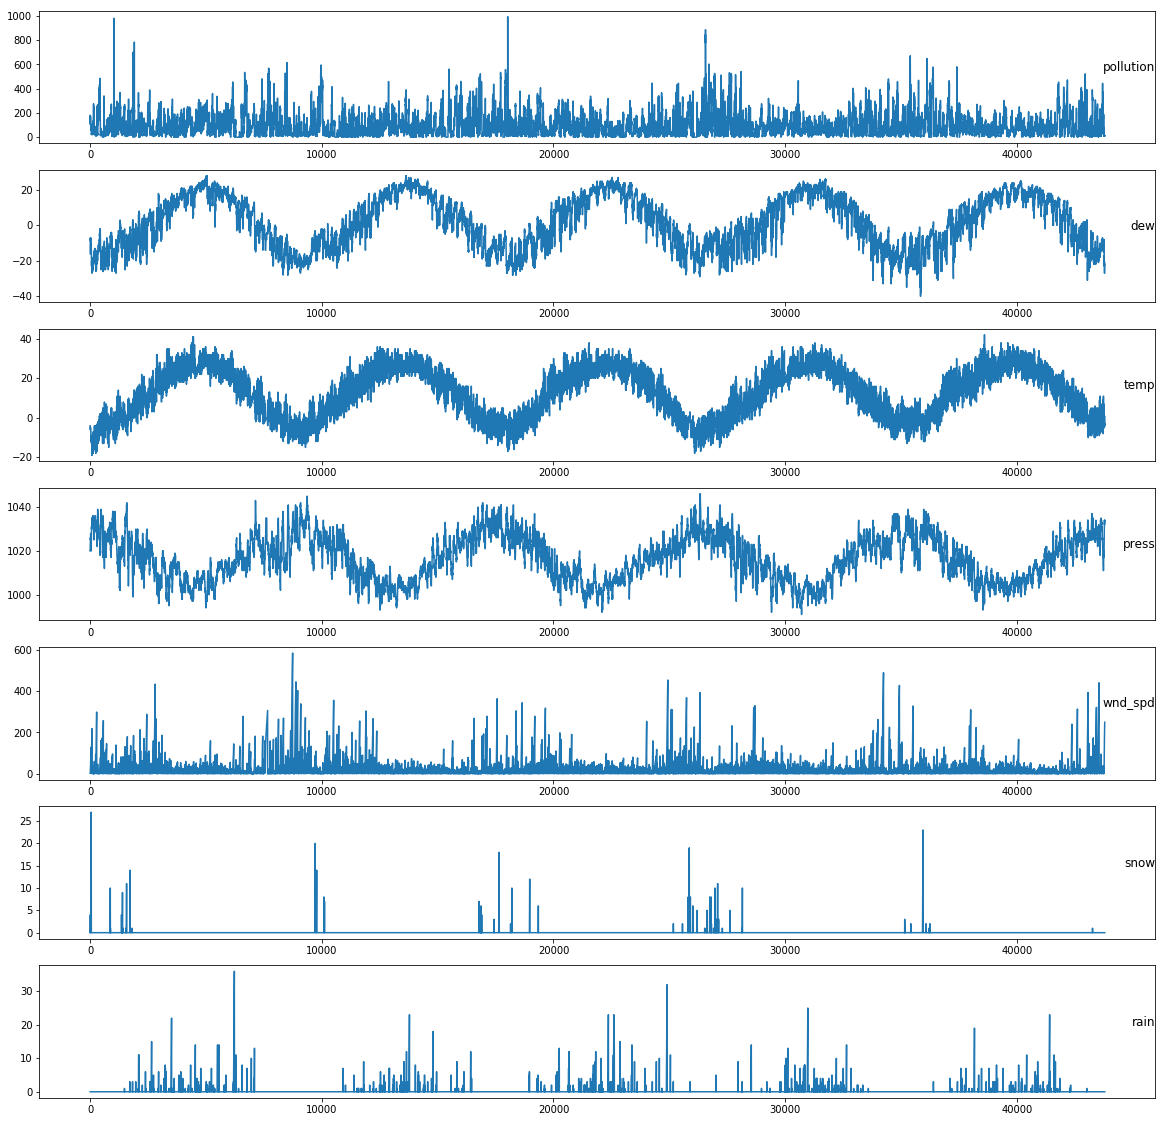

In [12]:
# load dataset
values = series.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(series.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

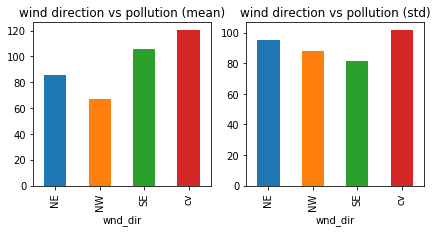

In [13]:
data = series
f,ax=plt.subplots(1,2,figsize=(7,3))

data.groupby(['wnd_dir'])['pollution'].mean().plot.bar(ax=ax[0])
ax[0].set_title('wind direction vs pollution (mean)')

data.groupby(['wnd_dir'])['pollution'].std().plot.bar(ax=ax[1])
ax[1].set_title('wind direction vs pollution (std)')

plt.show()

### Feature Engineering

In [14]:
from tsfresh.feature_extraction.feature_calculators import absolute_sum_of_changes, mean_change

In [15]:
window1 = int(5)
features=["wnd_spd","temp"]
feature_name = "_mean_change"

add_feat = series[features].rolling(window1).progress_apply(mean_change).reset_index()
add_feat.columns = ["date"]+[c+feature_name + "_window" + str(window1) for c in features]
add_feat=add_feat.set_index(["date"],drop=True)
series = series.merge(add_feat, left_index=True, right_index=True, how="left")

87592it [00:01, 59485.26it/s]


In [16]:
# convert time series into supervised learning problem
def series_to_supervised(data, features, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols1, cols2, names1, names2 = list(), list(), list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols1.append(df.shift(i))
        names1 += [(features[j]+'(t-%d)' % i) for j in range(n_vars)]
        cols2.append(df.shift(1).diff(i))
        names2 += [(features[j]+'_d(t-%d)' % i) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols1.append(df.shift(-i))
        cols2.append(df.diff(-i))
        if i == 0:
            names1 += [(features[j]+'(t+0)') for j in range(n_vars)]
            names2 += [(features[j]+'_d(t+0)') for j in range(n_vars)]
        else:
            names1 += [(features[j]+'(t+%d)' % i) for j in range(n_vars)]
            names2 += [(features[j]+'_d(t+%d)' % i) for j in range(n_vars)]
    # put it all together
    agg1 = pd.concat(cols1, axis=1)
    agg1.columns = names1
    agg2 = pd.concat(cols2, axis=1)
    agg2.columns = names2
    agg = pd.concat([agg1,agg2],axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Additional preprocessing

1. Category features encoding by using Target encoding (month, weekday, hour)

2. Make stationary time series from features and target. Differeces and Box-Cox transform for variance

In [17]:
# transform series into train and test sets for supervised learning
def preprocessing_data(series, cols_to_drop, target, n_train, n_lag, n_seq):
    # extract raw values
    series = series.dropna(how="any", axis=0)
    series = series.drop(cols_to_drop, axis=1)

    max_window=5
    train, test = series[0:n_train], series[n_train+max_window:]
    # you can add validation part too
    # series[n_train+largest_window:], prevent overfitting to nearest points to train

    train_y = train[target]
    train_x = train.drop(target, axis=1)
    train_time = pd.DataFrame(train.index)
    test_y = test[target]
    test_x = test.drop(target, axis=1)
    test_time = pd.DataFrame(test.index)

    features = train_x.columns
    cat_features=["wnd_dir"] # to be label encoded

    encoder = LabelEncoder()
    train_x[cat_features] = encoder.fit_transform(train_x[cat_features])
    test_x[cat_features] = encoder.transform(test_x[cat_features])

    scaler_x = MinMaxScaler(feature_range=(0,1))
    train_x = scaler_x.fit_transform(train_x)
    test_x = scaler_x.transform(test_x)

    scaler_y = MinMaxScaler(feature_range=(0,1))
    train_y = scaler_y.fit_transform(train_y)
    test_y = scaler_y.transform(test_y)

    train_x = series_to_supervised(train_x, features, n_lag, n_for)
    test_x = series_to_supervised(test_x, features, n_lag, n_for)
    train_time = series_to_supervised(train_time, ["date"], n_lag, n_for)
    train_y = series_to_supervised(train_y, target, n_lag, n_for)
    test_y = series_to_supervised(test_y, target, n_lag, n_for)
    test_time = series_to_supervised(test_time, ["date"], n_lag, n_for)

    searchfor = ["(t\+"+str(i)+")" for i in range(0,n_for)]+["_d(t\+"+str(i)+")" for i in range(0,n_for)]
    features_x = ~train_x.columns.str.contains('|'.join(searchfor))
    target_cols = [target[0]+"(t+"+str(i)+")" for i in range(0,n_for)]
    lag_cols = [target[0]+"(t-"+str(i)+")" for i in range(1,n_lag+1)]
    dif_cols = [target[0]+"_d(t-"+str(i)+")" for i in range(1,n_lag+1)]

    train_Y = train_y[target_cols]
    test_Y = test_y[target_cols]

    train_X = pd.concat([train_x.loc[:,features_x], train_y[lag_cols+dif_cols]], axis=1)
    test_X = pd.concat([test_x.loc[:,features_x], test_y[lag_cols+dif_cols]], axis=1)
    
    return scaler_y, train_X, train_Y, test_X, test_Y, train_time, test_time

In [18]:
# configure
n_lag=5
n_features=10
n_for=3
n_train=2*365*24 # 2 years in train
n_obs=n_lag*n_features

# prepare data
cols_to_drop=["unix_timestamp"]
target=["pollution"]

scaler_y, train_X, train_Y, test_X, test_Y, train_time, test_time = preprocessing_data(series, cols_to_drop, target, 
                                                                                       n_train, n_lag, n_for)

### Feature Selection

In [19]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [20]:
rfc = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1, max_features=0.2, random_state=17)

boruta_selector = BorutaPy(rfc, max_iter=100, n_estimators='auto', verbose=2)
boruta_selector.fit(train_X.values, train_Y['pollution(t+2)'].values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	9 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	10 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	11 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	12 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	13 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	14 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	15 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	16 / 100
Confirmed: 	27
Tenta

BorutaPy(alpha=0.05,
     estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=193, n_jobs=-1,
           oob_score=False,
           random_state=<mtrand.RandomState object at 0x7fae52898828>,
           verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7fae52898828>,
     two_step=True, verbose=2)

In [21]:
# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)

feature_df = pd.DataFrame(train_X.columns, columns=['features'])
feature_df['rank']=pd.Series(boruta_selector.ranking_)
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))

# check ranking of features
print ('\n Feature ranking:')
print (boruta_selector.ranking_)


 Number of selected features:
33

 Top 33 features:
                            features  rank
0                     wnd_spd_d(t-5)     1
1                           dew(t-1)     1
2                          temp(t-1)     1
3                       wnd_dir(t-1)     1
4                       wnd_spd(t-1)     1
5   wnd_spd_mean_change_window5(t-1)     1
6                         dew_d(t-5)     1
7                   pollution_d(t-4)     1
8    temp_mean_change_window5_d(t-5)     1
9                         dew_d(t-4)     1
10                    wnd_spd_d(t-4)     1
11   temp_mean_change_window5_d(t-4)     1
12                        dew_d(t-3)     1
13                    wnd_spd_d(t-3)     1
14   temp_mean_change_window5_d(t-3)     1
15                        dew_d(t-2)     1
16                    wnd_spd_d(t-2)     1
17                    wnd_spd_d(t-1)     1
18                    pollution(t-1)     1
19                    pollution(t-2)     1
20                    pollution(t-3)     1
2

In [22]:
selected_boruta = list(feature_df[feature_df["rank"] == 1]["features"])

In [23]:
train_X[selected_boruta].head()

,wnd_spd_d(t-5),dew(t-1),temp(t-1),wnd_dir(t-1),wnd_spd(t-1),wnd_spd_mean_change_window5(t-1),dew_d(t-5),pollution_d(t-4),temp_mean_change_window5_d(t-5),dew_d(t-4),...,pollution_d(t-1),pollution_d(t-2),pollution_d(t-3),wnd_dir(t-2),temp(t-2),pollution_d(t-5),wnd_dir(t-5),dew(t-2),wnd_dir(t-3),wnd_dir(t-4)
6,0.013757,0.375000,0.233333,0.666667,0.023669,0.908025,0.000000,0.023469,0.064516,0.000000,...,0.012245,0.008163,0.027551,0.666667,0.216667,-0.006122,0.666667,0.357143,0.666667,0.666667
7,0.017585,0.375000,0.233333,0.666667,0.029018,0.910114,0.000000,0.035714,0.096774,0.000000,...,0.008163,0.020408,0.016327,0.666667,0.233333,0.031633,0.666667,0.375000,0.666667,0.666667
8,0.019875,0.357143,0.233333,0.666667,0.034367,0.912203,-0.017857,0.028571,0.032258,-0.017857,...,0.012245,0.020408,0.032653,0.666667,0.233333,0.047959,0.666667,0.375000,0.666667,0.666667
9,0.022165,0.357143,0.233333,0.666667,0.039716,0.914292,-0.017857,0.028571,0.032258,0.000000,...,-0.004082,0.008163,0.016327,0.666667,0.233333,0.024490,0.666667,0.357143,0.666667,0.666667
10,0.025976,0.357143,0.233333,0.666667,0.046586,0.917768,0.000000,0.032653,0.032258,-0.017857,...,0.016327,0.012245,0.024490,0.666667,0.233333,0.044898,0.666667,0.357143,0.666667,0.666667


In [24]:
train_X = train_X[selected_boruta]
test_X = test_X[selected_boruta]

In [ ]:
#train_X = train_X.as_matrix().reshape((train_X.shape[0], n_lag, n_features))
#test_X = test_X.as_matrix().reshape((test_X.shape[0], n_lag, n_features))

#train_Y = train_Y.as_matrix().reshape((train_Y.shape[0], train_Y.shape[1]))
#test_Y = test_Y.as_matrix().reshape((test_Y.shape[0], test_Y.shape[1]))

### Correlations

In [25]:
def CorrelationSelector(X,y):
    columns = X.columns
    corr_data = dict([(abs(np.corrcoef(X[c],y)[0,1]),c) for c in columns if math.isnan(abs(np.corrcoef(X[c],y)[0,1]))==False])
    sorted_corr_data = sorted(corr_data.items(), key=operator.itemgetter(0), reverse=True)
    return sorted_corr_data

In [26]:
CorrelationSelector(train_X,train_Y.iloc[:,2])

[(0.8615770473722464, 'pollution(t-1)'),
 (0.8168322148620951, 'pollution(t-2)'),
 (0.7749510715030706, 'pollution(t-3)'),
 (0.73627887959901, 'pollution(t-4)'),
 (0.7003912575071317, 'pollution(t-5)'),
 (0.2893665614318387, 'pollution_d(t-5)'),
 (0.26631087194520425, 'pollution_d(t-4)'),
 (0.2603457986001341, 'wnd_dir(t-2)'),
 (0.2601157375286775, 'wnd_dir(t-3)'),
 (0.25720963274778663, 'wnd_dir(t-4)'),
 (0.2566462439095639, 'wnd_dir(t-5)'),
 (0.2509979838184614, 'wnd_dir(t-1)'),
 (0.23956318700279852, 'wnd_spd(t-1)'),
 (0.2381429947950487, 'pollution_d(t-3)'),
 (0.23355019324831117, 'dew(t-1)'),
 (0.22705296646704626, 'dew(t-2)'),
 (0.2013381603885502, 'pollution_d(t-2)'),
 (0.17017177708493517, 'dew_d(t-5)'),
 (0.1532150675008945, 'dew_d(t-4)'),
 (0.14304659763082664, 'pollution_d(t-1)'),
 (0.13299288598739278, 'dew_d(t-3)'),
 (0.10787516202097266, 'dew_d(t-2)'),
 (0.06585909873585463, 'temp_mean_change_window5_d(t-5)'),
 (0.0498197067565933, 'temp_mean_change_window5_d(t-4)'),
 (0.

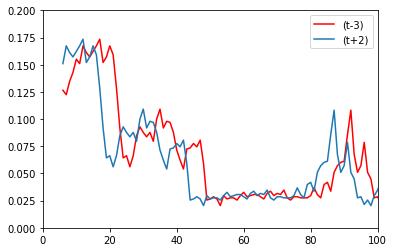

In [27]:
train_X['pollution(t-3)'].plot(c="red")
train_Y['pollution(t+2)'].plot()
plt.xlim([0,100])
plt.ylim([0,0.2])
plt.legend(['(t-3)','(t+2)'])

### Deep Learning models

### Multilayer perceptron

In [28]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import regularizers

In [29]:
output_file_name='Model_ANN_relu'

batch_size=72
epochs=50
output_size=3

In [30]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [33]:
# 64 x 32 x 8, lambda = 0.01, he_uniform
    #kernel_initializer='he_uniform' больше подходит для функции активации ReLu
    # create model
model = Sequential()
model.add(Dense(64, input_shape=(33,), kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(8, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(output_size, kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('linear'))
    
model.compile(loss='mae', metrics=['mae'],
                  optimizer='adam')

In [34]:
history = model.fit(train_X.values, train_Y.values,
          batch_size=batch_size,
          validation_data=(train_X.values, train_Y.values),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

Train on 17512 samples, validate on 17512 samples
Epoch 1/50
17512/17512 [==============================] - 1s 71us/step - loss: 1.1023 - mean_absolute_error: 0.0696 - val_loss: 0.4348 - val_mean_absolute_error: 0.0581
Epoch 2/50
17512/17512 [==============================] - 1s 60us/step - loss: 0.2381 - mean_absolute_error: 0.0536 - val_loss: 0.1375 - val_mean_absolute_error: 0.0566
Epoch 3/50
17512/17512 [==============================] - 1s 51us/step - loss: 0.1010 - mean_absolute_error: 0.0504 - val_loss: 0.0921 - val_mean_absolute_error: 0.0555
Epoch 4/50
17512/17512 [==============================] - 1s 57us/step - loss: 0.0761 - mean_absolute_error: 0.0459 - val_loss: 0.0872 - val_mean_absolute_error: 0.0564
Epoch 5/50
17512/17512 [==============================] - 1s 44us/step - loss: 0.0681 - mean_absolute_error: 0.0397 - val_loss: 0.0942 - val_mean_absolute_error: 0.0617
Epoch 6/50
17512/17512 [==============================] - 1s 44us/step - loss: 0.0639 - mean_absolute_err

Epoch 50/50
17512/17512 [==============================] - 1s 49us/step - loss: 0.0586 - mean_absolute_error: 0.0264 - val_loss: 0.0886 - val_mean_absolute_error: 0.0541


In [ ]:
# loss и MAE различаются

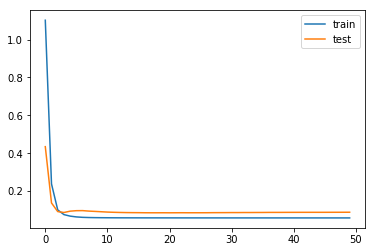

In [35]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [36]:
y_pred = model.predict(test_X.values)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.values.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [37]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 67.131 Test R2: 0.472
Test RMSE: 69.044 Test R2: 0.402
Test RMSE: 70.513 Test R2: 0.324


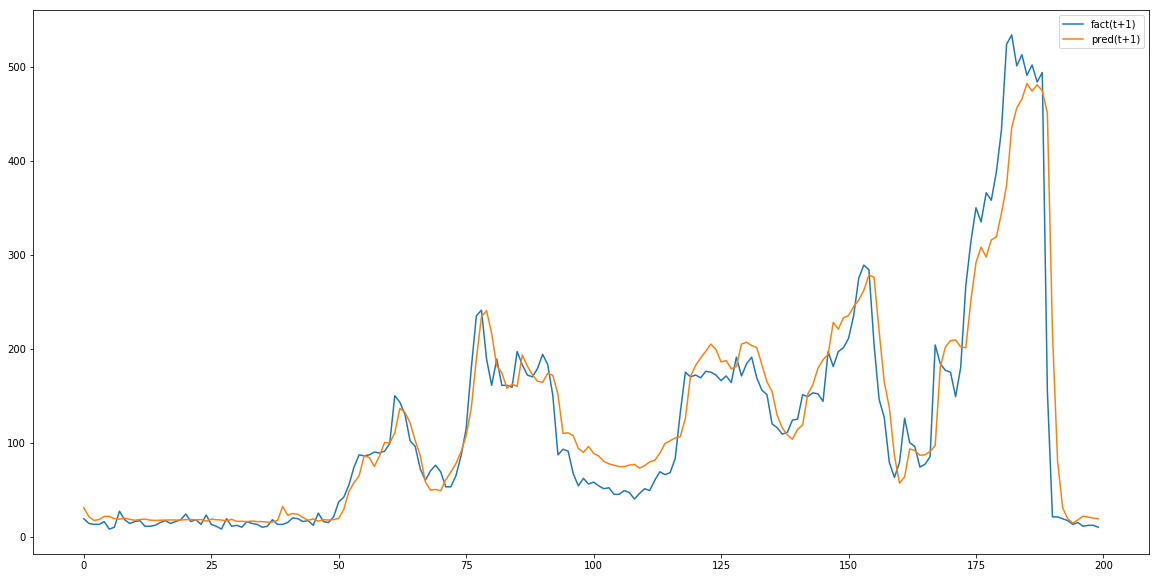

In [40]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,0][:200])
plt.plot(y_pred.iloc[:,0][:200])
plt.legend()
plt.show()

### Long Short-Term Memory Networks

In [41]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import LSTM, LeakyReLU
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import regularizers

output_file_name='Model_LSTM_relu'

units=50
batch_size=72
epochs=50
output_size=3
regb = regularizers.l2(0.01)
regW = regularizers.l2(0.001)

In [ ]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [42]:
train_X = train_X.as_matrix().reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.as_matrix().reshape((test_X.shape[0],1,test_X.shape[1]))

train_Y = train_Y.as_matrix().reshape((train_Y.shape[0], train_Y.shape[1]))
test_Y = test_Y.as_matrix().reshape((test_Y.shape[0], test_Y.shape[1]))

In [ ]:
https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss
    
#Remember - that if you use any kind of regularization - it affects your loss. Your actual loss is equal to:
#loss = mse + regularization
#and this is where your discrepancy comes from.

In [43]:
#build model
model = Sequential()
#model.add(LSTM(units=units, input_shape=(train_X.shape[1], train_X.shape[2]))), input_dim=32, 
#batch_input_shape=(batch_size,1,30), 
model.add(LSTM(units=units, input_dim=33, bias_regularizer=regb, recurrent_regularizer=regW, return_sequences=False))
model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Dense(output_size))
model.add(LeakyReLU())
model.compile(loss='mae', metrics=['mae'], optimizer='adam')
history = model.fit(train_X, train_Y,
          batch_size=batch_size,
          validation_data=(train_X, train_Y),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

Train on 17512 samples, validate on 17512 samples
Epoch 1/50
17512/17512 [==============================] - 2s 118us/step - loss: 0.4422 - mean_absolute_error: 0.0412 - val_loss: 0.3220 - val_mean_absolute_error: 0.0260
Epoch 2/50
17512/17512 [==============================] - 2s 93us/step - loss: 0.2467 - mean_absolute_error: 0.0223 - val_loss: 0.1854 - val_mean_absolute_error: 0.0233
Epoch 3/50
17512/17512 [==============================] - 2s 94us/step - loss: 0.1397 - mean_absolute_error: 0.0215 - val_loss: 0.1039 - val_mean_absolute_error: 0.0229
Epoch 4/50
17512/17512 [==============================] - 2s 88us/step - loss: 0.0776 - mean_absolute_error: 0.0212 - val_loss: 0.0587 - val_mean_absolute_error: 0.0225
Epoch 5/50
17512/17512 [==============================] - 2s 103us/step - loss: 0.0450 - mean_absolute_error: 0.0211 - val_loss: 0.0363 - val_mean_absolute_error: 0.0222
Epoch 6/50
17512/17512 [==============================] - 1s 83us/step - loss: 0.0298 - mean_absolute_e

Epoch 50/50
17512/17512 [==============================] - 1s 81us/step - loss: 0.0198 - mean_absolute_error: 0.0197 - val_loss: 0.0240 - val_mean_absolute_error: 0.0239


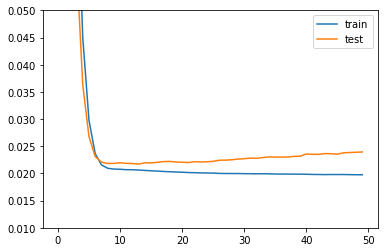

In [44]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [45]:
y_pred = model.predict(test_X)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [46]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 26.854 Test R2: 0.912
Test RMSE: 38.175 Test R2: 0.814
Test RMSE: 52.292 Test R2: 0.654


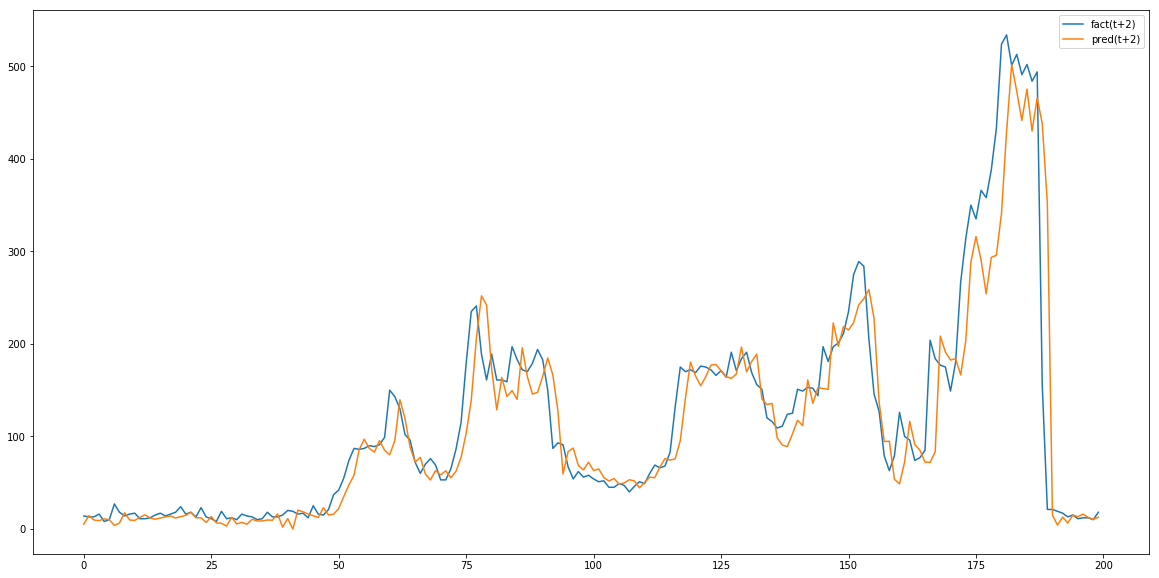

In [49]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,1][:200])
plt.plot(y_pred.iloc[:,1][:200])
plt.legend()
plt.show()

### General Recurrent Unit 

In [57]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.layers import GRU
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

output_file_name='Model_GRU_relu'

units=50
batch_size=72
epochs=50
output_size=3
regb = regularizers.l2(0.01)
regW = regularizers.l2(0.001)

In [58]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [60]:
#build model
model = Sequential()
model.add(GRU(units=units, input_dim=33,return_sequences=False))
model.add(Activation('tanh'))
#model.add(Dropout(0.2))
model.add(Dense(output_size))
model.add(Activation('relu'))
model.compile(loss='mae', metrics=['mae'], optimizer='adam')
history = model.fit(train_X, train_Y,
          batch_size=batch_size,
          validation_data=(test_X, test_Y),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

Train on 17512 samples, validate on 26263 samples
Epoch 1/50
17512/17512 [==============================] - 3s 147us/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422
Epoch 2/50
17512/17512 [==============================] - 2s 91us/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 3/50
17512/17512 [==============================] - 1s 81us/step - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 4/50
17512/17512 [==============================] - 2s 86us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 5/50
17512/17512 [==============================] - 1s 84us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 6/50
17512/17512 [==============================] - 1s 85us/step - loss: 0.0216 - mean_absolute_er

Epoch 50/50
17512/17512 [==============================] - 2s 98us/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217


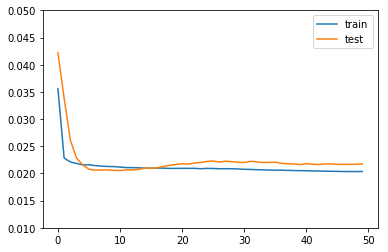

In [61]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [62]:
y_pred = model.predict(test_X)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [63]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 26.024 Test R2: 0.916
Test RMSE: 37.748 Test R2: 0.819
Test RMSE: 46.598 Test R2: 0.720


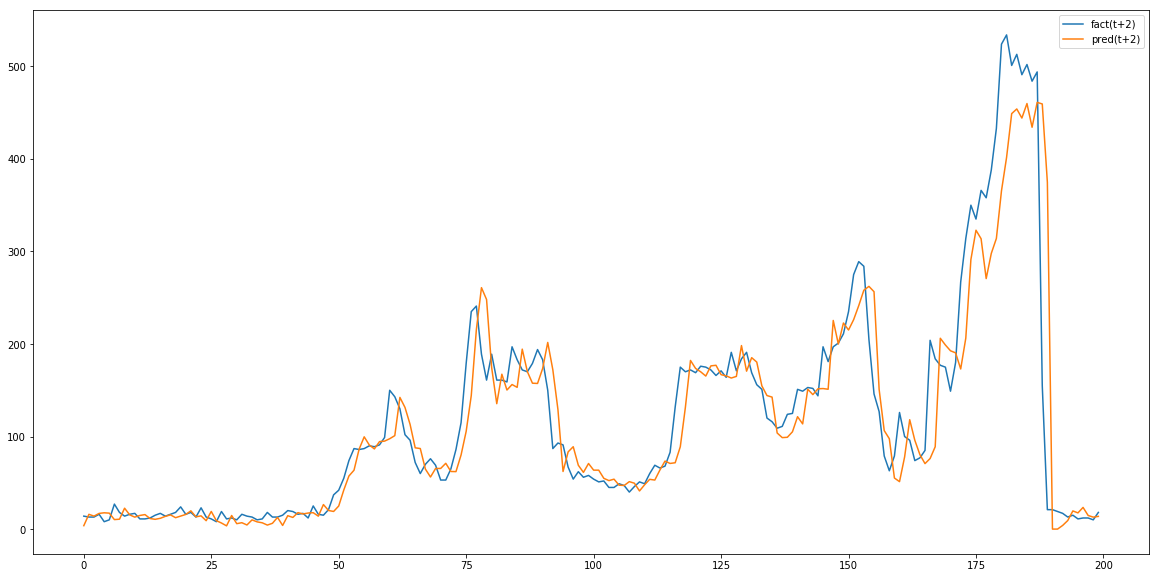

In [64]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,1][:200])
plt.plot(y_pred.iloc[:,1][:200])
plt.legend()
plt.show()